In [1]:
import nibabel as nib
from nilearn import glm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.io import loadmat 
import h5py, datetime
from scipy.signal import convolve
%matplotlib inline

/home/jmlee/.conda/envs/encoding/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


In [2]:
layername = ['/conv1','/conv2','/conv3','/conv4','/conv5','/fc6','/fc7','/fc8']

In [3]:
srate = 30
p  = [5, 16, 1, 1, 6, 0, 32]
tr = 1/srate


# hrf
reference: https://github.com/poldracklab/poldracklab-base/blob/master/fmri/spm_hrf.py

In [4]:
import scipy.stats
import numpy as N

def spm_hrf(TR,p=[5,16,1,1,6,0,32]):
    """ An implementation of spm_hrf.m from the SPM distribution
Arguments:
Required:
TR: repetition time at which to generate the HRF (in seconds)
Optional:
p: list with parameters of the two gamma functions:
                                                     defaults
                                                    (seconds)
   p[0] - delay of response (relative to onset)         6
   p[1] - delay of undershoot (relative to onset)      16
   p[2] - dispersion of response                        1
   p[3] - dispersion of undershoot                      1
   p[4] - ratio of response to undershoot               6
   p[5] - onset (seconds)                               0
   p[6] - length of kernel (seconds)                   32
"""

    p=[float(x) for x in p]

    fMRI_T = 16.0

    TR=float(TR)
    dt  = TR/fMRI_T
    u   = N.arange(p[6]/dt + 1) - p[5]/dt
    hrf=scipy.stats.gamma.pdf(u,p[0]/p[2],scale=1.0/(dt/p[2])) - scipy.stats.gamma.pdf(u,p[1]/p[3],scale=1.0/(dt/p[3]))/p[4]
    good_pts=N.array(range(N.int(p[6]/TR)))*int(fMRI_T)
    hrf=hrf[list(good_pts)]    
    hrf = hrf/N.sum(hrf)
    return hrf

In [5]:
poldrack_hrf = spm_hrf(tr,p)
print(poldrack_hrf.shape)

poldrack_hrf = np.expand_dims(poldrack_hrf, -1)
print(poldrack_hrf.shape)

print(poldrack_hrf.dtype)
poldrack_hrf = np.array(poldrack_hrf, dtype=np.float32)
print(poldrack_hrf.dtype)

(960,)
(960, 1)
float64
float32


/home/jmlee/.conda/envs/encoding/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


# load .mat

(961,)


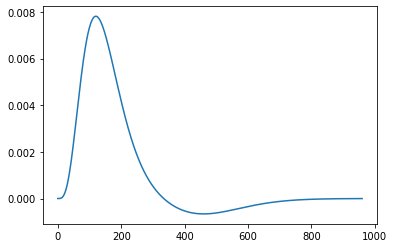

In [6]:
mat_file = loadmat('./hrf_variable.mat')
mat_hrf = np.squeeze(mat_file['hrf'])
print(mat_hrf.shape)
plt.plot(mat_hrf)

# plotting hrf 
first: poldrack_hrf 

(960, 1)


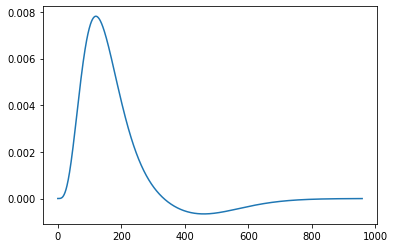

In [7]:
print(poldrack_hrf.shape)
plt.plot(poldrack_hrf)

# run_bivariate.m_training

In [6]:
dataroot = '/local_raid3/03_user/jungmin/02_data/Encoding_decoding/encoding_analyzing/02_Goal-Driven-DL/01_NeuralEncodingDecoding/sourcecode/source_code_v2/source_code_v2/feature_extracted/'
saveroot = '/local_raid3/03_user/jungmin/02_data/Encoding_decoding/encoding_analyzing/02_Goal-Driven-DL/01_NeuralEncodingDecoding/sourcecode/source_code_v2/source_code_v2/jlee_feature_extracted/'

In [7]:
def print_time():
    now = datetime.datetime.now()
    print("{}Y-{}M-{}D, {}H-{}m-{}s".format(now.year, now.month, now.day, now.hour, now.minute, now.second))

In [14]:
for seg in range(1,18):
    secpath = dataroot + 'AlexNet_feature_maps_seg'+ str(seg)+'.h5'

    for lay in range(0,len(layername)):
        print('Seg: ',  str(seg) , '; Layer: ',layername[lay])
        print_time()
        lay_feat = h5py.File(secpath, 'r')
        lay_feat = lay_feat[layername[lay] + '/data']
        lay_feat = lay_feat.value
        dim = lay_feat.shape
        dim=np.asarray(dim)
        print(dim)
        Nu = np.prod(dim[1:])
        print(Nu)
        Nf = dim[0]
        print(Nf)
        lay_feat = np.reshape(lay_feat,(Nf,Nu))
        print(lay_feat.shape) 
        print_time()
        if lay < len(layername):   
            lay_feat = np.log10(lay_feat + 0.01)
        print("Log10 applied!")
        print_time()     
        
        ts = convolve(poldrack_hrf, lay_feat)
        print("Convold2d Done!")
        print_time()
        ts = ts[4*srate+1:4*srate+Nf, :]
        down_sample_idx = np.arange(srate+1, len(ts), srate*2)
        ts = ts[down_sample_idx]
        # ts =ts.reshape((dim[1:], 240))
        print("Down sampled ts: {}".format(ts.shape))
        print_time()
        
        foldpath = saveroot+'AlexNet_feature_maps_processed_seg' + str(seg)+'.h5'
        f = h5py.File(foldpath, 'w')
        g = f.create_group(layername[lay])
        data = g.create_dataset("data", data=ts)
        print("Saved: {}".format(foldpath))
        print_time()
        f.close()

Seg:  1 ; Layer:  /conv1
2022Y-5M-24D, 23H-36m-4s
[14400    96    55    55]
290400
14400
(14400, 290400)
2022Y-5M-24D, 23H-36m-7s


/home/jmlee/.conda/envs/encoding/lib/python3.7/site-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if __name__ == "__main__":


Log10 applied!
2022Y-5M-24D, 23H-38m-20s
Convold2d Done!
2022Y-5M-24D, 23H-40m-29s


TypeError: only integer scalar arrays can be converted to a scalar index

In [52]:
# Checking
load_w = h5py.File(foldpath, 'r')
load_w[layername[lay] + '/data'].value.shape

/home/jmlee/.conda/envs/encoding/lib/python3.7/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


(240, 290400)

# Debug by Sungwoo

In [10]:
seg = 1
secpath = dataroot + 'AlexNet_feature_maps_seg'+ str(seg)+'.h5'

lay = 0
print('Seg: ',  str(seg) , '; Layer: ',layername[lay])
print_time()
lay_feat = h5py.File(secpath, 'r')
lay_feat = lay_feat[layername[lay] + '/data']
lay_feat = lay_feat.value
dim = lay_feat.shape
print(dim)

Seg:  1 ; Layer:  /conv1
2022Y-4M-25D, 18H-18m-13s
(14400, 96, 55, 55)


/home/jmlee/.conda/envs/encoding/lib/python3.7/site-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if __name__ == "__main__":


In [11]:
Nu = np.prod(dim[1:])
print(Nu)
Nf = dim[0]
print(Nf)
lay_feat = np.reshape(lay_feat,(Nf,Nu))
print(lay_feat.shape) 
print_time()
if lay < len(layername):   
    lay_feat = np.log10(lay_feat + 0.01)
print("Log10 applied!")
print_time()     

290400
14400
(14400, 290400)
2022Y-4M-25D, 18H-18m-16s
Log10 applied!
2022Y-4M-25D, 18H-20m-27s


In [32]:
print(type(poldrack_hrf), type(lay_feat))
print(poldrack_hrf.dtype, lay_feat.dtype)
print(poldrack_hrf.shape, lay_feat.shape)
print_time()

ts = convolve2d(poldrack_hrf, lay_feat)
print("Convold2d Done!")
print_time()

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
float32 float16
(960, 1) (14400, 290400)
2022Y-4M-25D, 18H-4m-21s


In [12]:
from scipy.signal import convolve

In [14]:
print(type(poldrack_hrf), type(lay_feat))
print(poldrack_hrf.dtype, lay_feat.dtype)
print(poldrack_hrf.shape, lay_feat.shape)
print_time()

ts = convolve(poldrack_hrf, lay_feat)
print("Convold Done!")
print_time()

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
float32 float16
(960, 1) (14400, 290400)
2022Y-4M-25D, 18H-21m-4s
Convold2d Done!
2022Y-4M-25D, 18H-26m-45s


In [15]:
ts.shape

(15359, 290400)

In [23]:
ts_ = loadmat("/check_correlation/ts.mat")
ts_ = ts_['ts_']
print(ts_.shape)

(15359, 100)


In [25]:
r_list = []
for i in range(100):
    r = np.corrcoef(ts[:,i], ts_[:,i])[0,1]
    r_list.append(r)
    
print(np.mean(r_list))
print(np.array_equal(ts,ts_))

0.999999999249486


# run_bivariate.m_testing

In [4]:
for test in range(1,5):
    secpath = dataroot + 'AlexNet_feature_maps_test'+ str(seg)+'.h5'

    for lay in range(0,len(layername)):
        print('Test: ',  str(test) , '; Layer: ',layername(lay))
        lay_feat = h5py.File(secpath,'r')
        lay_feat = lay_feat.get(layername[lay]+'/data').value
        dim = lay_feat.shape
        print(dim)
        Nu = np.prod(dim[1:])
        print(Nu)
        Nf = dim[0]
        print(Nf)
        lay_feat = np.reshape(lay_feat,(Nf,Nu))
        print(lay_feat.shape)      
        if lay < len(layername):   
            lay_feat = np.log10(lay_feat + 0.01)
        ts = convolve(poldrack_hrf, lay_feat)
        ts = ts[4*srate+1:4*srate+Nf, :]
        down_sample_idx = np.arange(srate+1, len(ts), srate*2)
        ts = ts[down_sample_idx]
        print("Down sampled ts: {}".format(ts.shape))

        foldpath = saveroot+'AlexNet_feature_maps_processed_test' + str(test)+'.h5'
        store = h5py.File(foldpath + layername(lay)+ '/data' + ts, 'w')

NameError: name 'seg' is not defined

In [21]:
dim = lay_feat.shape
print(dim)
Nu = np.prod(dim[1:])
print(Nu)
Nf = dim[0]
print(Nf)

lay_feat = np.reshape(lay_feat,(Nf,Nu))
print(lay_feat.shape)

(14400, 96, 55, 55)
290400
14400
(14400, 290400)


# Convolution

In [27]:
from scipy.signal import convolve2d
ts = convolve2d(poldrack_hrf, lay_feat[:10])

In [ ]:
print(ts.shape)

In [ ]:
ts = ts[4*srate:4*srate+Nf, :]

In [25]:
down_sample_idx = np.arange(srate+1, len(ts), srate*2)
ts = ts[down_sample_idx]

(240,)

In [ ]:
print(ts)

# Check_data_load_.h5file

In [9]:
featuremap = h5py.File('./stimuli2/AlexNet_feature_maps_seg1.h5','r')
print(featuremap.keys())
featuremap_val = featuremap.get('/conv1/data').value


<KeysViewHDF5 ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8']>


/home/jmlee/.conda/envs/encoding/lib/python3.7/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
featuremap_val= featuremap_val.flatten()

In [10]:
featuremap_val.shape

(14400, 96, 55, 55)

In [82]:
lay_file.shape

(4181760000,)

In [83]:
corr = np.corrcoef(lay_feat,lay_file)

In [84]:
corr

array([0.])

In [46]:
alex_file = h5py.File('./frames/AlexNet_feature_maps_seg1.h5','r')
alex_file.keys()
alex_file = alex_file.get('/conv1/data').value


/home/jmlee/.conda/envs/encoding/lib/python3.7/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
alex_file[1]

array([[[5.3406e+01, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00,
         8.8047e+00, 0.0000e+00],
        [1.5695e+01, 2.9863e+00, 0.0000e+00, ..., 0.0000e+00,
         0.0000e+00, 2.5371e+00],
        [0.0000e+00, 4.0406e+01, 0.0000e+00, ..., 0.0000e+00,
         0.0000e+00, 8.5312e+00],
        ...,
        [1.0953e+01, 0.0000e+00, 4.8031e+01, ..., 3.7094e+01,
         9.5947e-01, 0.0000e+00],
        [8.4375e+00, 0.0000e+00, 3.0078e+01, ..., 9.5000e+01,
         0.0000e+00, 3.6602e+00],
        [1.3016e+01, 2.9844e+00, 1.8953e+01, ..., 4.7156e+01,
         0.0000e+00, 2.5732e-01]],

       [[0.0000e+00, 0.0000e+00, 1.4625e+02, ..., 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0310e+03, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.2694e+02, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00,
         3.7719e+01, 9.4438e+01],
        ...,
        [8.2891e+00, 0.0000e+00, 1.4746e+00, ..., 0.0000e+00,
         3.6600e+02, 2.8225e+02],
        [0.0

In [51]:
np.min(alex_file)

0.0

In [22]:
lay_feat = np.log10(lay_feat)
poldrack_hrf = np.expand_dims(poldrack_hrf, -1)
print(poldrack_hrf.shape)

(960, 1)


/home/jmlee/.conda/envs/encoding/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
